bankruptcy 資料前處理

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
### 1. Null (or Missing) Values Estimation ###

file_path = "bankruptcy(predict brankrupt or not).csv"
bank_data = pd.read_csv(file_path)
# print(bank_data.head())
if 'Unnamed: 0' in bank_data.columns:
    bank_data = bank_data.drop(columns=['Unnamed: 0'])
print("Number of Null (or Missing) Values: \n", bank_data.isnull().sum())

imputer = KNNImputer(n_neighbors=10)
bank_filled = pd.DataFrame(imputer.fit_transform(bank_data), columns=bank_data.columns)
# bank_filled.to_csv("bank_clean.csv", index=False)
print("------------------------------------------------------")
print("After Filling, Number of Null (or Missing) Values: \n", bank_filled.isnull().sum())

Number of Null (or Missing) Values: 
 Bankrupt?                                                     0
 ROA(C) before interest and depreciation before interest     98
 ROA(A) before interest and % after tax                     100
 ROA(B) before interest and depreciation after tax           98
 Operating Gross Margin                                     100
                                                           ... 
 Liability to Equity                                        100
 Degree of Financial Leverage (DFL)                          99
 Interest Coverage Ratio (Interest expense to EBIT)          99
 Net Income Flag                                            100
 Equity to Liability                                        100
Length: 96, dtype: int64
------------------------------------------------------
After Filling, Number of Null (or Missing) Values: 
 Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 

In [3]:
### 2. Data Balance ###

label_col = 'Bankrupt?'
x = bank_filled.drop(label_col, axis=1)
y = bank_filled[label_col]
print("Original class distribution: ")
print(Counter(y))

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
print("\nClass distribution after balancing: ")
print(Counter(y_resampled))

Original class distribution: 
Counter({0.0: 6599, 1.0: 220})

Class distribution after balancing: 
Counter({1.0: 6599, 0.0: 6599})


In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [5]:
### 3. Feature Selection ###

features = x.columns
print(f"Number of Original Features: {len(features)}")
print(f"Feature Name: {list(features)}\n")

# XGBoost
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(x_resampled, y_resampled)

selector = SelectFromModel(model, threshold="mean", prefit=True)
x_selected = selector.transform(x_resampled)

selected_features = x.columns[selector.get_support()]
print(f"Number of Features After Selection: {len(selected_features)}")
print(f"Reserved Feature Names: {list(selected_features)}")
threshold_value = np.mean(model.feature_importances_)
print(f"Feature selection threshold: {threshold_value}")

Number of Original Features: 95
Feature Name: [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate'

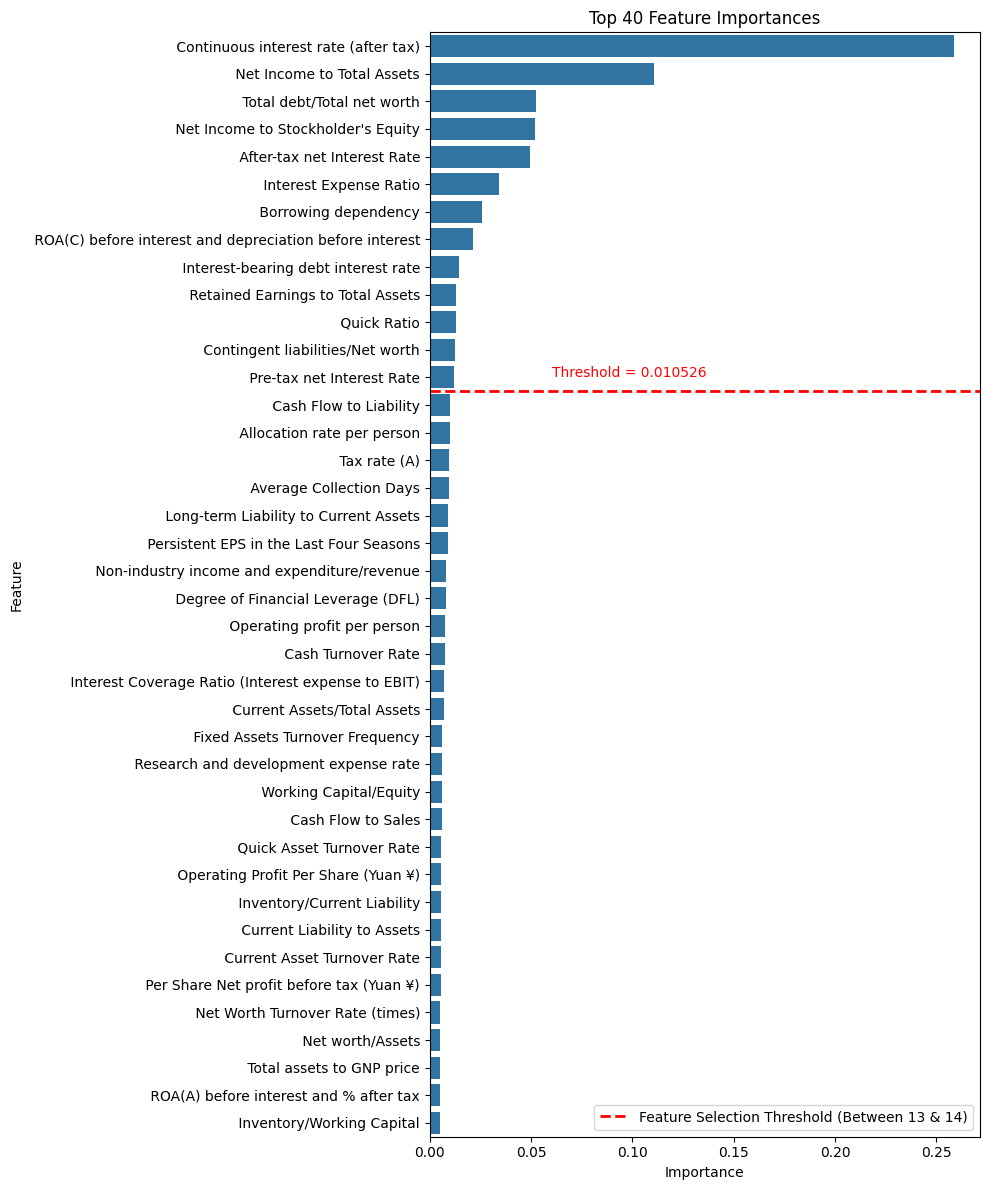

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': model.feature_importances_
})

top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(40).reset_index(drop=True)
threshold_position = 12.5

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("Top 40 Feature Importances")
plt.axhline(y=threshold_position, color='red', linestyle='--', linewidth=2, label='Feature Selection Threshold (Between 13 & 14)')
plt.text(
    x=threshold_value + 0.05,
    y=threshold_position - 0.5,
    s=f"Threshold = {threshold_value:.6f}",
    color='red',
    fontsize=10,
)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
### 4. Save Files ###

x_final = pd.DataFrame(x_selected, columns=selected_features)
final_df = pd.concat([x_final, y_resampled.reset_index(drop=True)], axis=1)
final_df.rename(columns={final_df.columns[-1]: 'Bankrupt?'}, inplace=True)

final_df.to_excel("bankruptcy_processed.xlsx", index=False)
final_df.to_csv("bankruptcy_processed.csv", index=False)

print("The files have been saved！")

The files have been saved！


diamonds 資料前處理

In [8]:
### 1. Null (or Missing) Values Estimation ###

file_path = "daimonds(predict price).csv"
diam_data = pd.read_csv(file_path)
# print(diam_data.head())
diam_data = diam_data.loc[:, ~diam_data.columns.str.startswith('Unnamed:')]
print("Number of Null (or Missing) Values: \n", diam_data.isnull().sum())

# Non-numeric: Use the majority value
for col in diam_data.select_dtypes(include='object').columns:
    most_common = diam_data[col].mode()[0]
    diam_data[col].fillna(most_common, inplace=True)

# Numeric: use KNNImputer
numeric_data = diam_data.select_dtypes(include='number')
non_numeric_data = diam_data.select_dtypes(exclude='number')

imputer = KNNImputer(n_neighbors=10)
numeric_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)
diam_filled = pd.concat([numeric_imputed, non_numeric_data.reset_index(drop=True)], axis=1)
# diam_filled.to_csv("diam_clean.csv", index=False)
print("------------------------------------------------------")
print("After Filling, Number of Null (or Missing) Values: \n", diam_filled.isnull().sum())

Number of Null (or Missing) Values: 
 carat      993
cut        989
color      992
clarity    995
depth      990
table      993
price      992
x          991
y          997
z          992
dtype: int64
------------------------------------------------------
After Filling, Number of Null (or Missing) Values: 
 carat      0
depth      0
table      0
price      0
x          0
y          0
z          0
cut        0
color      0
clarity    0
dtype: int64


In [9]:
### 3. Feature Selection ###

label_col = 'price'
x = diam_filled.drop(label_col, axis=1)
y = diam_filled[label_col]

features = x.columns
print(f"Number of Original Features: {len(features)}")
print(f"Feature Name: {list(features)}\n")

# Label Encoding
for col in x.select_dtypes(include='object').columns:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col])

# XGBoost
model = XGBRegressor(random_state=42, eval_metric='rmse')
model.fit(x, y)

selector = SelectFromModel(model, threshold="mean", prefit=True)
x_selected = selector.transform(x)

selected_features = x.columns[selector.get_support()]
print(f"Number of Features After Selection: {len(selected_features)}")
print(f"Reserved Feature Names: {list(selected_features)}")

Number of Original Features: 9
Feature Name: ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']

Number of Features After Selection: 2
Reserved Feature Names: ['carat', 'y']


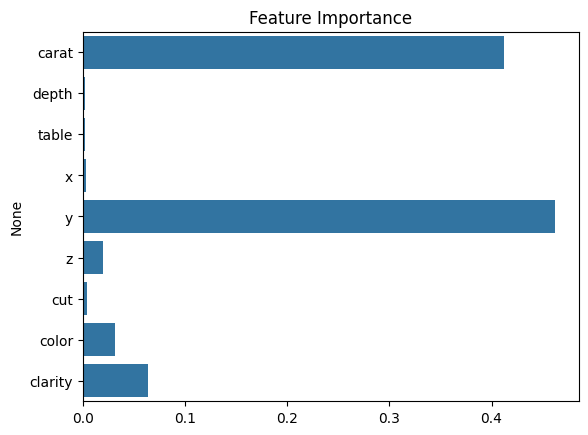

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
sns.barplot(x=importances, y=x.columns)
plt.title("Feature Importance")
plt.show()

In [11]:
### 4. Save Files ###

x_final = pd.DataFrame(x_selected, columns=selected_features)
final_df = pd.concat([x_final, y.reset_index(drop=True)], axis=1)
final_df.rename(columns={final_df.columns[-1]: 'price'}, inplace=True)

final_df.to_excel("diamonds_processed.xlsx", index=False)
final_df.to_csv("diamonds_processed.csv", index=False)

print("The files have been saved！")

The files have been saved！
